# Gas turbine combustor in Cantera using constant volume reactor

Description:

What to explain in my paper:
GRI 3.0 Mechanism
PFR,CSTR Reactor
Gas Turbine Combustor
How does Cantera calculate
CO2 - O2 - CH4 Turbine Cycle
Data outcome

Sources:
-Cantera documentation and code examples:
https://www.cantera.org/docs/sphinx/html/reactors.html
https://www.cantera.org/docs/sphinx/html/cython/examples/reactors_combustor.html#py-example-combustor-py
https://www.cantera.org/docs/sphinx/html/cython/examples/reactors_pfr.html#py-example-pfr-py
-cerfacs tutorial
http://www.cerfacs.fr/cantera/docs/tutorials/CANTERA_HandsOn.pdf

Importing necessery libraries

In [1]:
import math
import csv
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

Model inputs

In [2]:
#thermodynamic parameters

T0_o2 = 300.0 #oxygen temperature [K]
T0_ch4 = 300.0 #methane temperature [K]
T0_co2 = 600.0 #carbon dioxide temperature [K]
p0 = 100000.0 #inlet preassure[Pa]
eqv = 0.8 #equivalence ratio
ftor = 0.25 #fuel to oxygen ratio
o2_mf = 45.0 #oxygen mass flow [kg/s]
co2_mf = 200.0 #carbon dioxide mass flow [kg/s]
ch4_mf = ftor*eqv*o2_mf
X = 0.2 #mixer/DZ co2 injection ratio

#geometrical parameters

Lc = 3.0 #combustor length [m]
Dc = 1.0 #combustor diameter [m]
D = 0.3 #mixing tube diameter [m]
Df = 0.1 #fuel port diameter [m]
mixer_length = 0.15 #[m]
PZ_length = 0.45 #[m]
SZ_length = 1.2 #[m]

#internal parameters

Kv = 500.0 #valve coefficient
dt = 1.0 #iteration step time [s]
N = 100000 #number of steps

Fuel, oxidizer, operating gas and igniter compositions

In [3]:
ch4 = ct.Solution('gri30.xml')
ch4.TPX = T0_ch4, p0, 'CH4:1.0'

o2 = ct.Solution('gri30.xml')
o2.TPX = T0_o2, p0, 'O2:1.0'

co2 = ct.Solution('gri30.xml')
co2.TPX = T0_co2, p0, 'CO2:1.0'

h = ct.Solution('gri30.xml')
h.TPX = 300.0, p0, 'H:1.0'

Creation of reservoirs

In [4]:
res_ch4 = ct.Reservoir(ch4)
res_o2 = ct.Reservoir(o2)
res_co2 = ct.Reservoir(co2)
res_igniter = ct.Reservoir(h)
res_exhaust = ct.Reservoir(co2)

Setting up a reactor network (CSTR cluster)

In [5]:
mixer_vol = mixer_length * D**2 * math.pi / 4
PZ_vol = PZ_length * Dc**2 * math.pi / 4

mixer = ct.IdealGasReactor(co2, energy = 'on')
mixer.volume = mixer_vol

PZ = ct.IdealGasReactor(co2, energy = 'on')
PZ_volume = PZ_vol

SZ = ct.IdealGasReactor(co2, energy = 'on')

ch4_mfc = ct.MassFlowController(res_ch4, mixer, mdot = ch4_mf)
o2_mfc = ct.MassFlowController(res_o2, mixer, mdot = o2_mf)
co2_mfc = ct.MassFlowController(res_co2, mixer, mdot = X*co2_mf)

mixer_v = ct.Valve(mixer, PZ, K = Kv)
PZ_v = ct.Valve(PZ, SZ, K = Kv)

#igniter
fwhm = 0.2
amplitude = 0.1
t0 = 1.0
igniter_mdot = lambda t: amplitude * math.exp(-(t-t0)**2 * 4 * math.log(2) / fwhm**2)
igniter_mfc = ct.MassFlowController(res_igniter, PZ, mdot = igniter_mdot)

Iteration of the CSTR cluster

In [6]:
sim = ct.ReactorNet([mixer, PZ])

#print('{0:>14s} {1:>14s} {2:>14s}  {3:>14s}  {4:>14s}'.format(
#'t [s]', 'T [K]', 'h [J/kg]', 'P [Pa]', 'X_CH4'))
t = 0.0

for n in range(150):
  t += 0.01
  sim.advance(t)
  #print('{0:14.5g} {1:14.5g} {2:14.5g}  {3:14.5g}  {4:14.5g}'.format(
  #t, PZ.T, PZ.thermo.h, PZ.thermo.P, PZ.thermo['CH4'].X[0]))

print(mixer.thermo.report())
print(PZ.thermo.report())


  gri30:

       temperature          417.24  K
          pressure          100000  Pa
           density        0.942089  kg/m^3
  mean mol. weight         32.6821  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -4.1241e+06       -1.348e+08     J
   internal energy     -4.2302e+06       -1.383e+08     J
           entropy          6869.2        2.245e+05     J/K
    Gibbs function     -6.9902e+06       -2.285e+08     J
 heat capacity c_p          1105.8        3.614e+04     J/K
 heat capacity c_v          851.41        2.783e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                O2       0.488946         0.478723         -25.5828
               CH4        0.19505        0.0957447          -45.794
               CO2       0.316004         0.425532         -140.545
     [  +50 minor]    -1.4

Setting up a reactor network (PFR cluster)

In [7]:
mass_flow_rate2 = ch4_mfc.mdot(t) + co2_mfc.mdot(t) + o2_mfc.mdot(t)
dz = SZ_length / N

SZ_vol = SZ_length * Dc**2 * math.pi / 4 / N
SZ_volume = SZ_vol

upstream = ct.Reservoir(co2)

downstream = ct.Reservoir(co2)

m = ct.MassFlowController(upstream, SZ, mdot=mass_flow_rate2)

v = ct.Valve(SZ, downstream, K = Kv)

Iteration of the PFR cluster

# Join both loops together!!!

In [8]:
sim2 = ct.ReactorNet([SZ])

# define time, space, and other information vectors
z2 = (np.arange(N) + 1) * dz
t_SZ = np.zeros_like(z2)  # residence time in each reactor
u2 = np.zeros_like(z2)
t2 = np.zeros_like(z2)
states2 = ct.SolutionArray(SZ.thermo)
# iterate through the PFR cells
for n in range(N):
    # Set the state of the reservoir to match that of the previous reactor
    co2.TDY = SZ.thermo.TDY
    upstream.syncState()
    # integrate the reactor forward in time until steady state is reached
    sim2.reinitialize()
    sim2.advance_to_steady_state(1000)
    # compute velocity and transform into time
    u2[n] = mass_flow_rate2 / (Dc**2 * math.pi / 4) / SZ.thermo.density
    t_SZ[n] = SZ.mass / mass_flow_rate2  # residence time in this reactor
    t2[n] = np.sum(t_SZ)
    # write output data
    states2.append(SZ.thermo.state)

Plotting

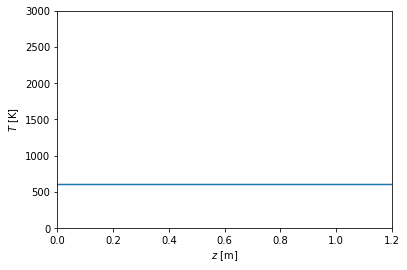

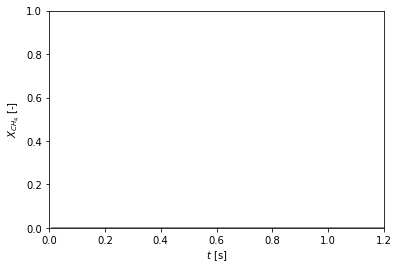

In [11]:
plt.figure()
plt.plot(z2, states2.T)
plt.xlabel('$z$ [m]')
plt.ylabel('$T$ [K]')
plt.axis([0, 1.2, 0, 3000])
plt.show()
#plt.savefig('pfr_T_z.png')

plt.figure()
plt.plot(t2, states2.X[:, co2.species_index('CH4')])
plt.xlabel('$t$ [s]')
plt.ylabel('$X_{CH_4}$ [-]')
plt.axis([0, 1.2, 0, 1])
plt.show()
#plt.savefig('pfr_XH2_t.png')